# Popularity of Song Prediction
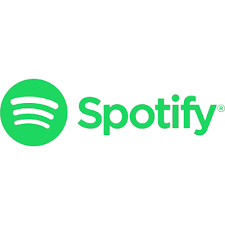

Our choice of dataset is the **Spotify Dataset** 1921-2020, 160k+ Tracks dataset from Kaggle. In our project we will be attempting to predict the popularity of a song in the Spotify dataset based upon other features in the dataset. Some of the features we plan on using as predictors are acousticness, danceability, energy, instrumentalness, energy, liveness, loudness, speechiness, tempo, and valence.

**Info on popularity score**
(according to Spotify for Developers - [Documentation](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-tracks/) / https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-tracks/)
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.

**Team Members:**



*   *Marianna Petrovich*
*   *Bijan Pourazari*
*   *Christian Salas*
*   *Michael Garber*


Importing packages we need


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

## Interpret the Data

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/BowieRules/cst383/master/data.csv")

### Data Fields

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   id                174389 non-null  object 
 7   instrumentalness  174389 non-null  float64
 8   key               174389 non-null  int64  
 9   liveness          174389 non-null  float64
 10  loudness          174389 non-null  float64
 11  mode              174389 non-null  int64  
 12  name              174389 non-null  object 
 13  popularity        174389 non-null  int64  
 14  release_date      174389 non-null  object 
 15  speechiness       174389 non-null  float64
 16  tempo             17

### Summary Of data

In [ ]:
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [ ]:
df.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,174389.000000,174389.000000,1.743890e+05,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000
mean,0.499228,0.536758,2.328100e+05,0.482721,0.068135,0.197252,5.205305,0.211123,-11.750865,0.702384,25.693381,0.105729,117.006500,0.524533,1977.061764
std,0.379936,0.176025,1.483958e+05,0.272685,0.251978,0.334574,3.518292,0.180493,5.691591,0.457211,21.872740,0.182260,30.254178,0.264477,26.907950
min,0.000000,0.000000,4.937000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1920.000000
25%,0.087700,0.414000,1.661330e+05,0.249000,0.000000,0.000000,2.000000,0.099200,-14.908000,0.000000,1.000000,0.035200,93.931000,0.311000,1955.000000
50%,0.517000,0.548000,2.057870e+05,0.465000,0.000000,0.000524,5.000000,0.138000,-10.836000,1.000000,25.000000,0.045500,115.816000,0.536000,1977.000000
75%,0.895000,0.669000,2.657200e+05,0.711000,0.000000,0.252000,8.000000,0.270000,-7.499000,1.000000,42.000000,0.076300,135.011000,0.743000,1999.000000
max,0.996000,0.988000,5.338302e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.971000,243.507000,1.000000,2021.000000


**Data Cleaning** is not required, no NANs present

In [ ]:
df.isna().sum().sum()

0

Looking at the correlation matrix for possible features to predict on.

# Data Visualization

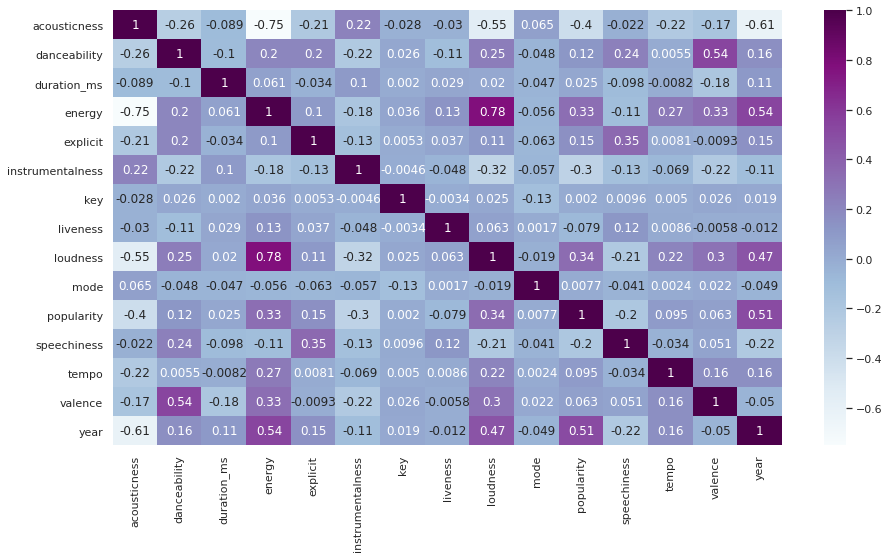

In [ ]:
plt.figure(figsize=(15, 8))
sns.set(style="dark")
corr = df.corr()
sns.heatmap(corr,annot=True,cmap="BuPu");

Now look in more details via scatter plots for closer look at correlations between certain features and popularity.

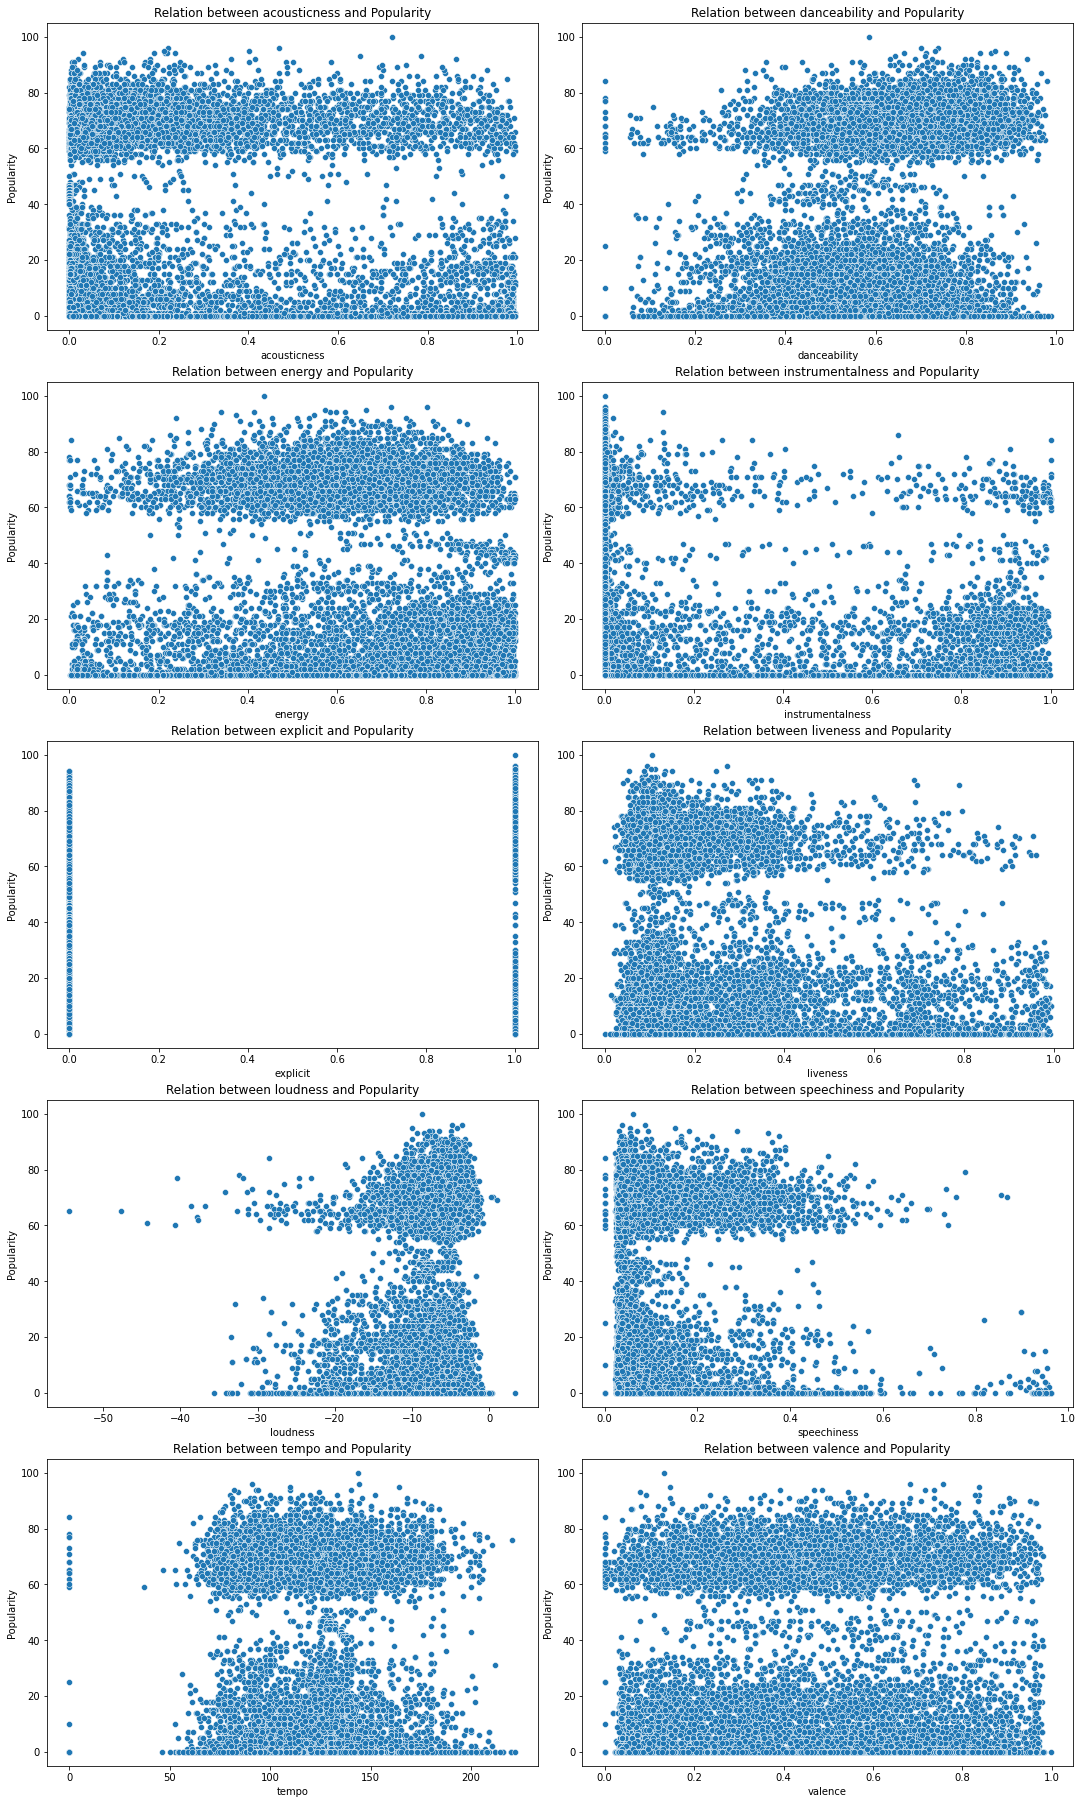

In [4]:
subset = df[df['year'] >= 2016]
variables = ['acousticness', 'danceability', 'energy','instrumentalness', 'explicit', 'liveness',
             'loudness', 'speechiness', 'tempo', 'valence']
year = range(2016,2021)

fig = plt.figure(figsize=(15,25))
for variable,num in zip(variables, range(1,len(variables)+1)):
    ax = fig.add_subplot(5,2,num)
    sns.scatterplot(x = variable, y = 'popularity', data=subset)
    plt.title('Relation between {} and Popularity'.format(variable))
    plt.xlabel(variable)
    plt.ylabel('Popularity')
fig.tight_layout(pad=0.5)

Our plan is to use subset of features to predict the popularity of the tracks. In order to pick the best features to start with, let's look at some feature and how they performed over time, as suggested by professor. We found the speechiness and acousticness to be most interesting to observe, specifically how these features are no longer relevant to the popularity of the song, while loudness, energy and danceability seem to have the most positive effect.

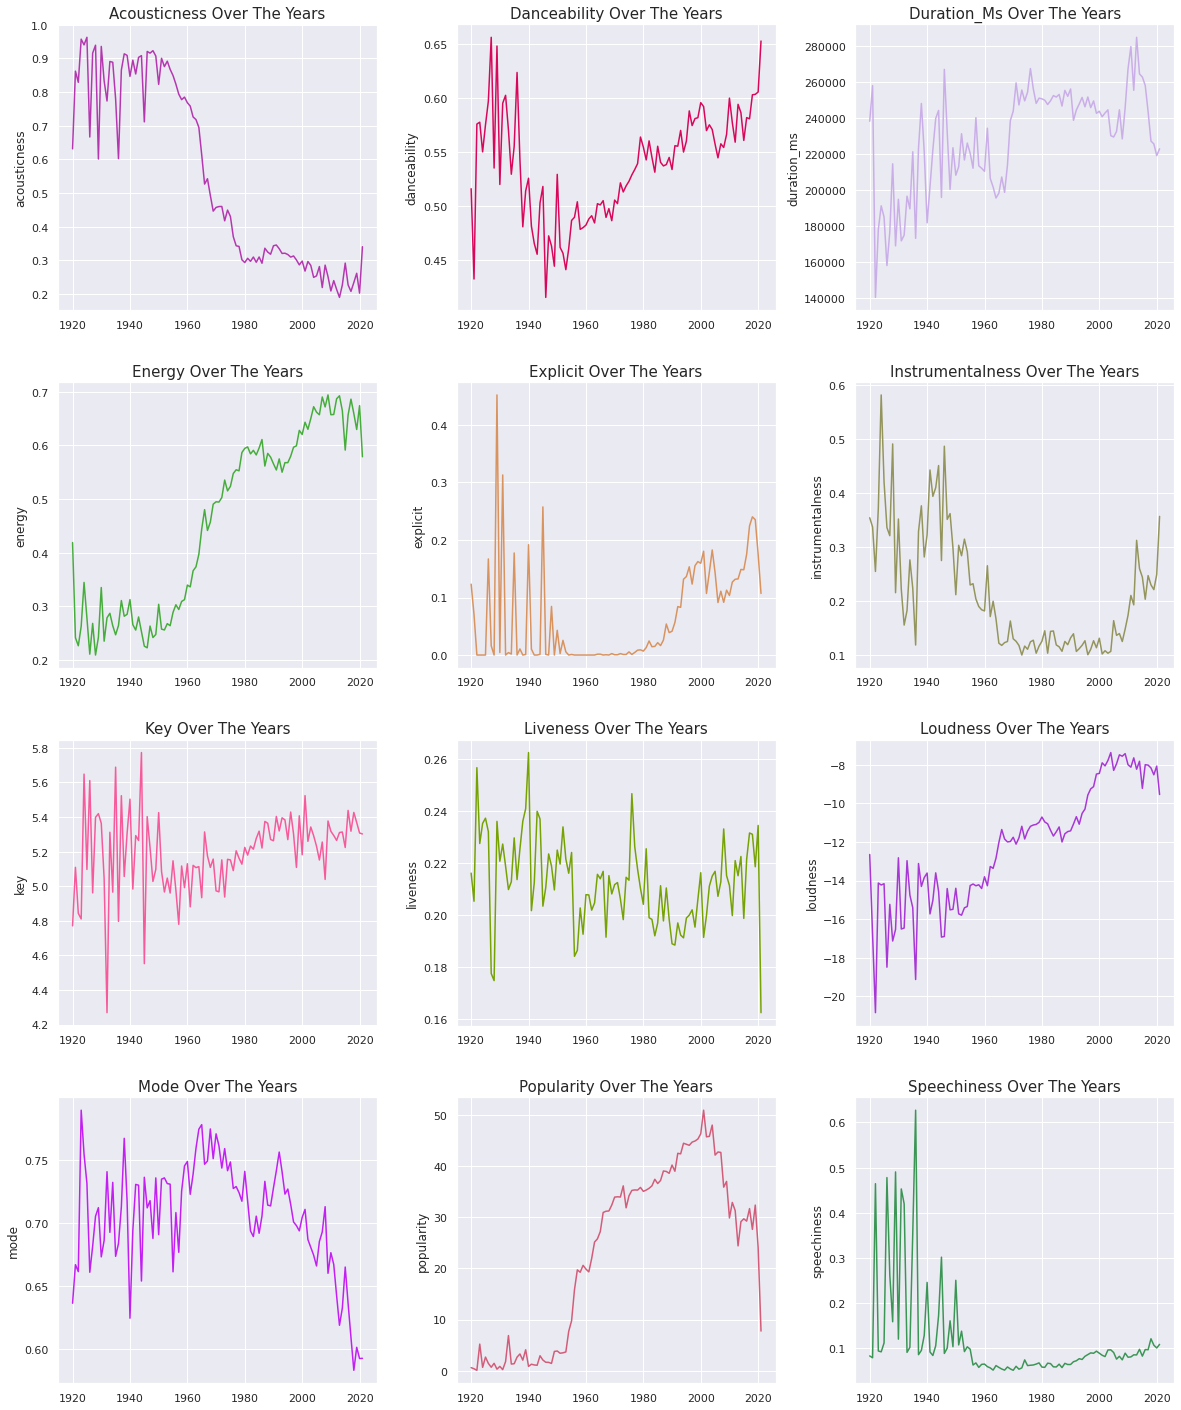

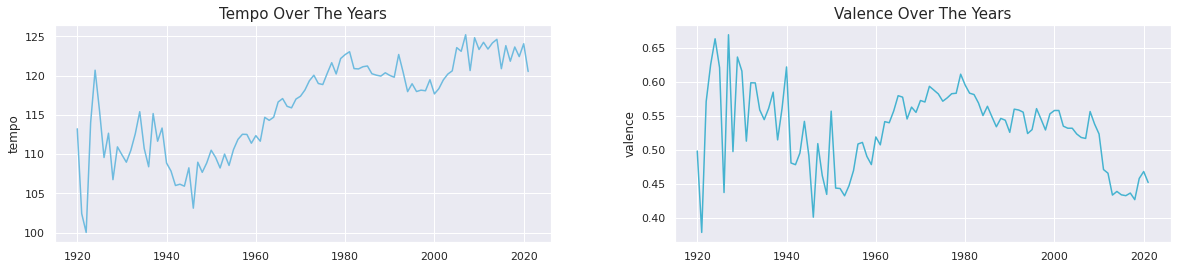

In [ ]:
groups = df[df['year']>=1920].groupby(['year']).mean()
fig, axes1 = plt.subplots(4, 3, figsize=(20, 25))
plt.subplots_adjust(hspace=0.25, wspace=0.25)
fig, axes2 = plt.subplots(1, 2, figsize=(20, 4))
plt.subplots_adjust(wspace=0.25)

for row in axes1:
    for ax in row:
        col = groups.columns[list(axes1.flatten()).index(ax)]
        ax.plot(groups.index, groups[col], color=np.random.rand(3))
        ax.set_title(str.title(col + ' over the years'), size=15)
        ax.set_ylabel(col)
        ax.grid(True)
        
for ax in axes2:
    col = groups.columns[list(axes2.flatten()).index(ax)+12]
    ax.plot(groups.index, groups[col], color=np.random.rand(3))
    ax.set_title(str.title(col + ' over the years'), size=15)
    ax.set_ylabel(col)
    ax.grid(True)

plt.show()

Therefore our first candidate features for predicting popularity of the songs are loudness, energy and danceability.

We are going to use **KNN Regressor** first.

# Machine Learning Models



```
# This is formatted as code
```

## Approach 1: KNNeighborsRegressor

In [5]:
def rmse(predicted, actual):
  return np.sqrt(((predicted - actual)**2).mean())

def plot_actual_predicted(actual, predicted, title):
    sns.scatterplot(x=actual, y=predicted, color=np.random.rand(3))
    plt.title(title)
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.grid()
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], color="black", linestyle="dashed", linewidth=2)

# pick predictors and target
predictors = ['loudness','energy','danceability','tempo','explicit','liveness']
X = subset[predictors].values
target = 'popularity'
y = subset[target].values

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# scaled version
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=22, algorithm='kd_tree', metric='euclidean', weights='distance')
knn.fit(X_train_sc, y_train)
predictions = knn.predict(X_test_sc)
print('blind MSE: {0:.6f}'.format(rmse(y_train.mean(), y_test)))
print('Test RMSE: {0:.6f}'.format(rmse(predictions, y_test)))

blind MSE: 31.124472
Test RMSE: 22.157149


In [ ]:
score=knn.score(X_test_sc, y_test)
print(score)

0.49297742728874494


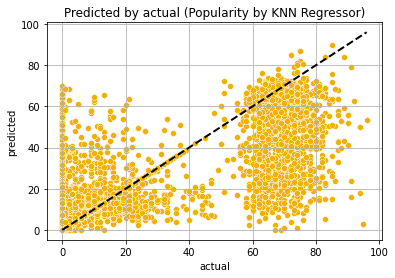

In [6]:
plot_actual_predicted(y_test, predictions, 'Predicted by actual (Popularity by KNN Regressor)')

## Approach 2: Linear Regression

In [ ]:
# Let's try linear regression
#drop target and non numeric fields
X = subset.drop(columns=["popularity","artists","id","name","release_date"]).values
target = 'popularity'
y = subset[target].values
pf = PolynomialFeatures(degree=2)
pf.fit(X)
X_poly = pf.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, random_state=0)
reg = LinearRegression()
reg.fit(X_train, y_train)
rmse = np.sqrt(((reg.predict(X_test)-y_test)**2).mean())
accuracy = reg.score(X_train,y_train)

print("RMSE: {:.2f}".format(rmse))
print("Accuracy: {:.2f}".format(accuracy))

RMSE: 23.10
Accuracy: 0.43


In [ ]:
scores = cross_val_score(LinearRegression(), X_train, y_train, scoring='neg_mean_squared_error', cv=10)
rmse = np.sqrt(-scores.mean())
print("RMSE: {:.2f}".format(rmse))

RMSE: 23.70


## Approach 3: RandomForestRegressor

In [ ]:
random_forest = RandomForestRegressor()

random_forest.fit(X_train, y_train)
Y_pred_rf = random_forest.predict(X_test)

In [ ]:
acc_random_forest = round(random_forest.score(X_test,y_test) * 100, 2)
print(acc_random_forest)

60.37


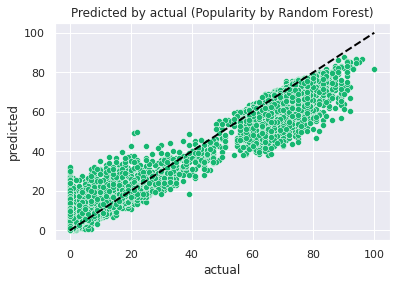

In [ ]:
# plot predicted vs. actual for random forest
plot_actual_predicted(y_train, random_forest.predict(X_train), 'Predicted by actual (Popularity by Random Forest)')

## Approach 4: XGBRegressor

In [ ]:
# fit model to training data
model = XGBRegressor(objective = 'reg:linear', verbosity = 0, random_state=0)
model.fit(X_train, y_train);

In [ ]:
acc_XGBoost = round(model.score(X_train,y_train) * 100, 2)
print(acc_XGBoost)

55.09


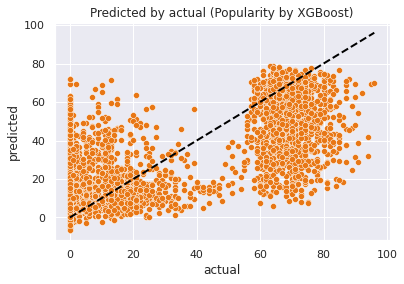

In [ ]:
plot_actual_predicted(y_test, model.predict(X_test), 'Predicted by actual (Popularity by XGBoost)')

## Approach 5: SVR

In [27]:
regr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100.0, epsilon=0.2))
regr.fit(X_train_sc, y_train)
y_pred = regr.predict(X_test_sc)

accuracy = regr.score(X_test_sc,y_test)
print(accuracy)

0.3001855654341732


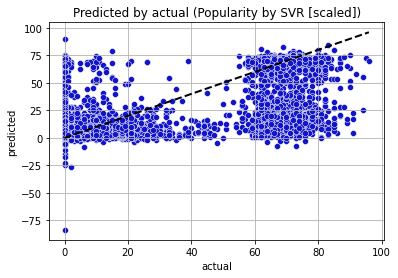

In [28]:
plot_actual_predicted(y_test, regr.predict(X_test_sc), 'Predicted by actual (Popularity by SVR [scaled])')